In [3]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import *

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

Evaluating a Learning Algorithm (Polynomial Regression)

In [7]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


Plot Train, Test sets

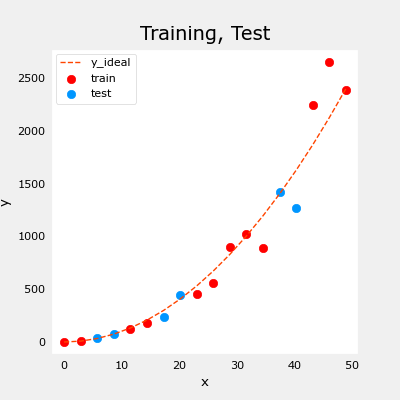

In [8]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

Error Calculation for Model Evaluation, Linear Regression

Exercise 1

In [10]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ###
        err_i  = ( (yhat[i] - y[i])**2 )
        err   += err_i
    err = err / (2*m)


    ### END CODE HERE ###

    return(err)

In [11]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)
# END UNIT TEST

 All tests passed.


Compare Performance on Training and Test data

In [12]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [13]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


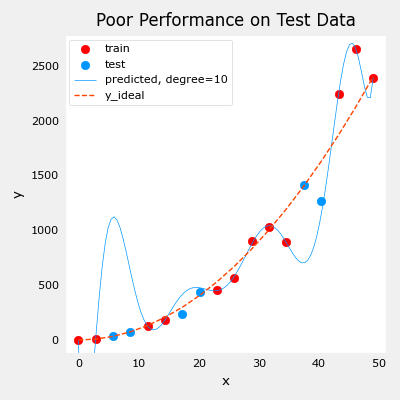

In [14]:
# plot predictions over data range
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

In [15]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


Bias and Variance

Plot Train Cross Validation Test

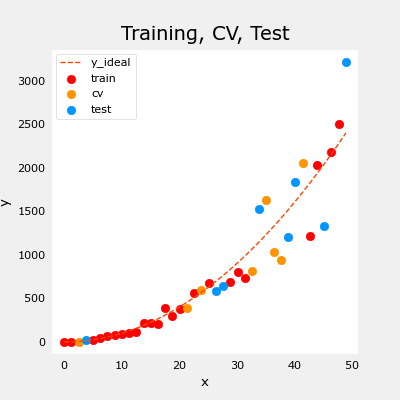

In [16]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [17]:
max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0,int(X.max()),100)
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv)+1

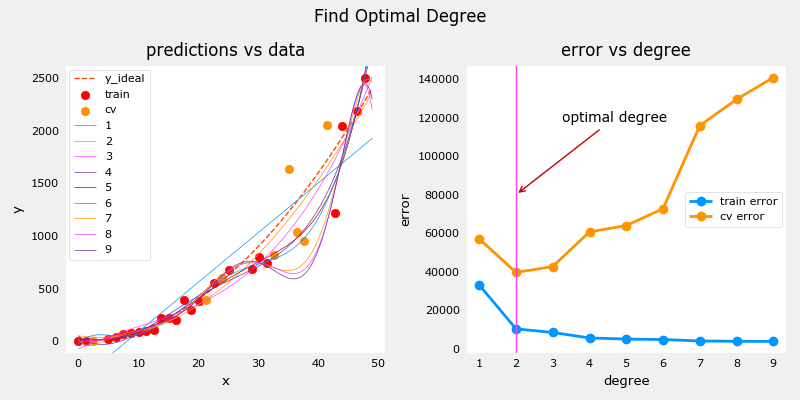

In [18]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal,
                   err_train, err_cv, optimal_degree, max_degree)

Tuning Regularization

In [19]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0,int(X.max()),100)
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

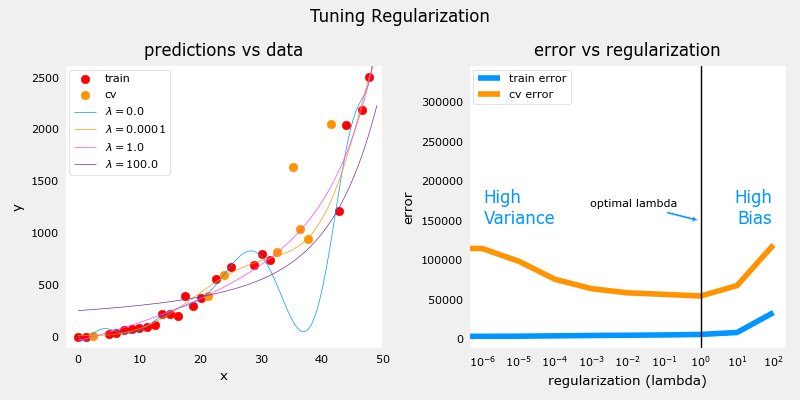

In [20]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Getting More Data increasing Training Set Size (m)

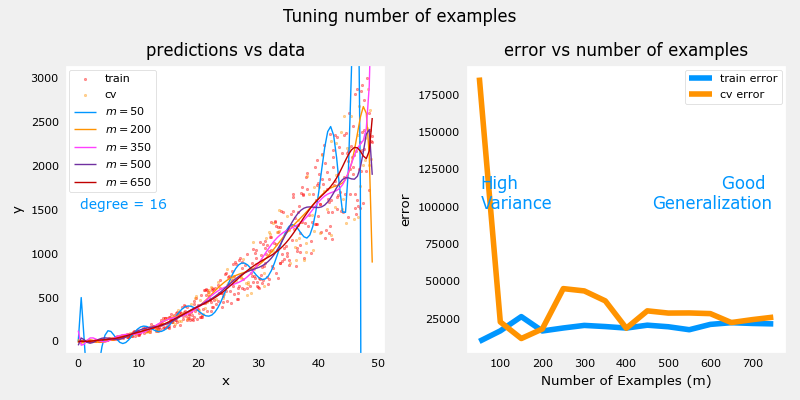

In [21]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

Evaluating a Learning Algorithm (Neural Network)

Data Set

In [22]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


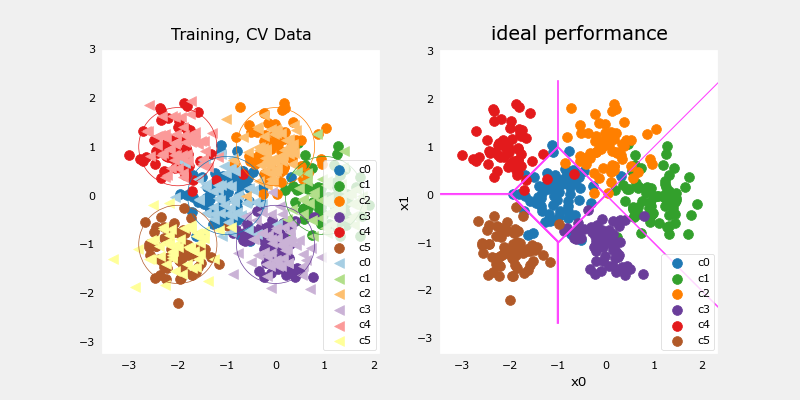

In [23]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Evaluating Categorical Model by Calculating Classification Error

Exercise 2

In [24]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ###
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m


    ### END CODE HERE ###

    return(cerr)

In [25]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.


Model Complexity

Complex Model

Exercise 3

In [26]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ###
        Dense(120, activation = 'relu', name = "L1"),
        Dense(40, activation = 'relu', name = "L2"),
        Dense(classes, activation = 'linear', name = "L3")
        ### END CODE HERE ###

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ###
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### END CODE HERE ###
)

In [28]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2900  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.4033
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.3725
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.2961
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.2505
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.2253
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.2141
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.2070
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.2055
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.2012
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.2004
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.1980
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.1960
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.1973
Epoch 15/1000
13/13 ━━━━━━━━━

In [29]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1])
# END UNIT TEST

Model: "Complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

AttributeError: The layer Complex has never been called and thus has no defined input.

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step


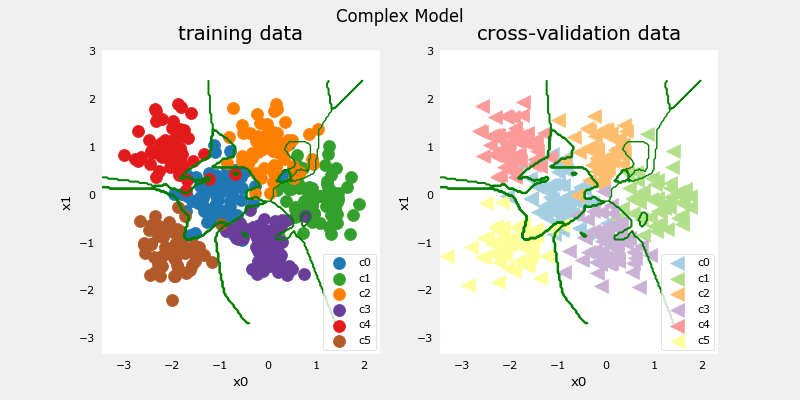

In [30]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [31]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
categorization error, training, complex model: 0.005
categorization error, cv,       complex model: 0.097


Simple Model

Exercise 4


In [32]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ###
        Dense(6, activation = 'relu', name="L1"),
        Dense(classes, activation = 'linear', name="L2")
        ### END CODE HERE ###
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ###
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ###
)


In [33]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=10
)
# END UNIT TEST

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 1.8185
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 1.5112
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2573
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 1.0491
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.8887
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.7599
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.6576
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.5759
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.5087
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.4535


In [ ]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 165us/step


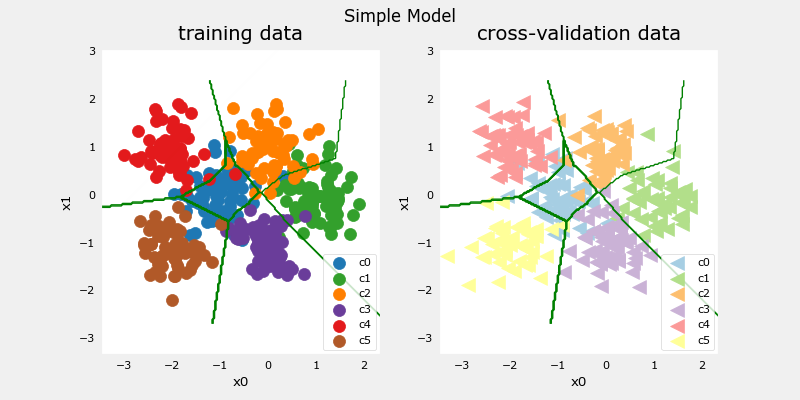

In [35]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [36]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
categorization error, training, simple model, 0.102, complex model: 0.005
categorization error, cv,       simple model, 0.091, complex model: 0.097


Regularization

Exercise 5

In [37]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ###
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"),
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),
        Dense(classes, activation = 'linear', name="L3")
        ### START CODE HERE ###
    ], name= "ComplexRegularized"
)
model_r.compile(
    ### START CODE HERE ###
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ###
)

In [38]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=100
)
# END UNIT TEST

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6688  
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 1.7075
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.3228
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 1.0959
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1.0025
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.9457
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.8925
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.8373
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.7970
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.7720
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.7566
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.7417
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.7254
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.7131
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [39]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1])
# END UNIT TEST

Model: "ComplexRegularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

ddd


AttributeError: The layer ComplexRegularized has never been called and thus has no defined input.

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step


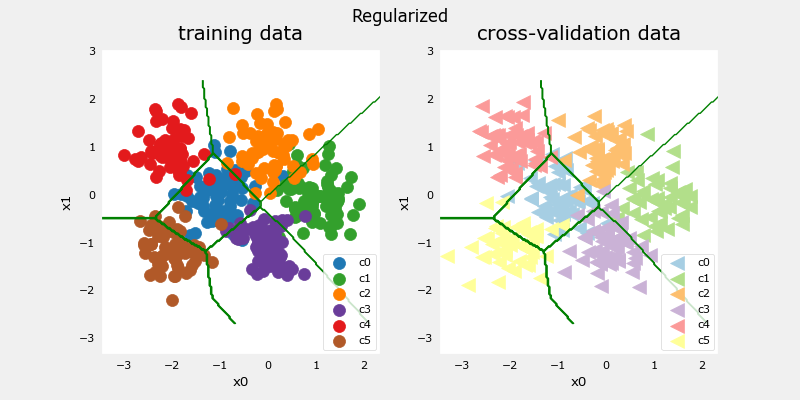

In [40]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)

plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [41]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
categorization error, training, regularized: 0.102, simple model, 0.102, complex model: 0.005
categorization error, cv,       regularized: 0.116, simple model, 0.091, complex model: 0.097


Iterate to find optimal Regularization Value

In [44]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=100
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3648  
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4318
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.3184
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.2566
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.2250
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.2170
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.2116
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.2038
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.1981
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.1944
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.1956
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.1936
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.1901
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.1897
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 89

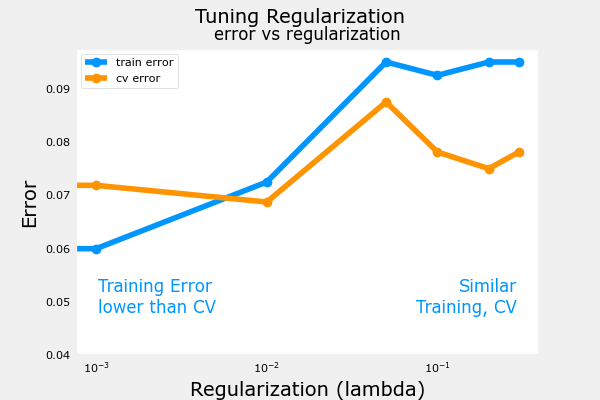

In [45]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

Try Optimized Model on Test Set

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 165us/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


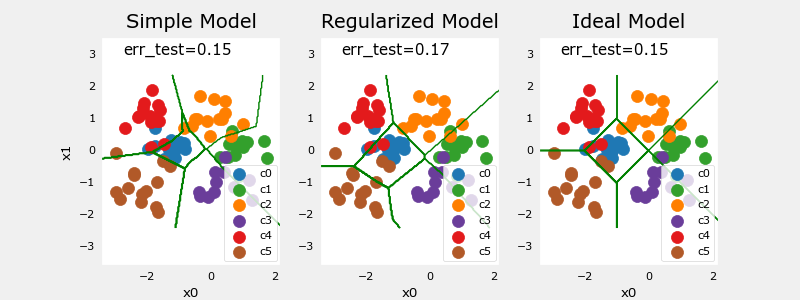

In [46]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)